# ASTR540 Homework 4
Noah Franz

In [60]:
import warnings
from functools import partial
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c
from astropy.table import vstack

from astroquery.gaia import Gaia
from astroquery.sdss import SDSS


### Problem 1
Proper Motion of Bo ̈otes III. Let’s revisit the proper motion of the disrupting satellite Bo ̈otes III,
as discussed in Carlin & Sand 2018. Since that study, there has been the 3rd data release of Gaia (Gaia DR3),
so it is possible that there are more proper motion members in the catalog, and that the overall uncertainties
have improved. 

a. First, go to Table 1 of the Carlin paper, which displays all of the ‘radial velocity confirmed’ members of Bo ̈otes III, and make your own table with updated proper motion values. 

b. By how much have the uncertainties going from Gaia DR2 to Gaia DR3 improved? Have there been any large changes in proper
motion for any of these stars (>5σ)? |

c. Calculate your own error-weighted proper motion to Bo ̈otes III, compare it with the DR2 value, and make a plot similar to Figure 1 of the paper. 

d. Try to identify further proper motion members in Bo ̈otes III, as described in Section 2.3 of the paper. Do the improved measurements of Gaia DR3 lead to more plausible proper motion members of Bo ̈otes III?

In [105]:
# read in the Table 1 data from Carin & Sand (2018)
data_dr2 = pd.read_csv("Carlin_and_Sand_2018_Table1.txt", sep="\t")

# and then clean it up
data_dr2 = data_dr2.dropna(how="all", axis=1)

data_dr2 = data_dr2.replace({
    "cdots": np.nan,
    "N" : False,
    "Y" : True
})

data_dr2["v_helio_err"] = [v.split(" +or- ")[1] if not pd.isna(v) else v for v in data_dr2.v_helio]
data_dr2["v_helio"] = [v.split(" +or- ")[0] if not pd.isna(v) else v for v in data_dr2.v_helio]

data_dr2["mu_alpha_err"] = [v.split(" +or- ")[1]  if not pd.isna(v) else v for v in data_dr2.mu_alpha]
data_dr2["mu_alpha"] = [v.split(" +or- ")[0]  if not pd.isna(v) else v for v in data_dr2.mu_alpha]

data_dr2["mu_delta_err"] = [v.split(" +or- ")[1]  if not pd.isna(v) else v for v in data_dr2.mu_delta]
data_dr2["mu_delta"] = [v.split(" +or- ")[0]  if not pd.isna(v) else v for v in data_dr2.mu_delta]

In [106]:
data_dr3 = []
idxs = []
radius = 1*u.arcsec

for i, row in data_dr2.iterrows():
    coord = SkyCoord(row.alpha, row.delta, unit=u.deg)
    job = Gaia.cone_search(coord, radius=radius)
    res = job.get_results()
    
    if len(res) != 1:
        warnings.warn(f"Length of result not equal to 1 for {row.source_id}!")
        continue
    
    data_dr3.append(res)
    idxs.append(i) # keep track of index for joining
    
data_dr3 = vstack(data_dr3).to_pandas()
data_dr3 = data_dr3.set_index(np.array(idxs))

/tmp/ipykernel_847230/39562995.py:11: UserWarning: Length of result not equal to 1 for -9223372036854775808!
  warnings.warn(f"Length of result not equal to 1 for {row.source_id}!")


In [107]:
data_dr3.columns = [c+"_dr3"  if "_dr3" not in c else c for c in data_dr3.columns]
data_dr2.columns = [c+"_dr2" if "_dr2" not in c else c for c in data_dr2.columns]

data = pd.merge(data_dr2, data_dr3, left_index=True, right_index=True, how="outer")

In [234]:
def get_sdss_colors(df, ra_key="ra", dec_key="dec", filters=["u", "g", "r", "i", "z"]):
    
    all_data = []
    
    for idx, row in df.iterrows():
        
        coord = SkyCoord(row[ra_key], row[dec_key], unit="deg")
        
        try:
            res = SDSS.query_region(
                coord, 
                radius=1*u.arcsec, 
                spectro=False,
                fields=["ra", "dec", "objid"] + filters,
            )
        except Exception as e:
            all_data.append(row)
            continue
            
        if res is None or not len(res):
            all_data.append(row)
            warnings.warn(f"Skipping {row.DESIGNATION} because no SDSS data!")
            continue
        
        res = res.to_pandas()
        
        res_filtered = res[res.g > -100]
        
        if not len(res):
            all_data.append(row)
            warnings.warn(f"Skipping {row.DESIGNATION} because no high quality SDSS data!")
            continue
        
        # take the u, g, r, i, z from the closest row 
        min_sep = np.argmin(
            coord.separation(
                SkyCoord(
                    res_filtered.ra.values, 
                    res_filtered.dec.values, 
                    unit="deg"
                )
            )
        )
        for filt in filters:
            row[f"{filt}_sdss"] = res_filtered[filt].values[min_sep]
        
        all_data.append(row)
        
    return pd.DataFrame(all_data)
        
data = get_sdss_colors(data, ra_key="ra_dr3", dec_key="dec_dr3")

data

,id_dr2,source_id_dr2,alpha_dr2,delta_dr2,g_dr2,r_dr2,i_dr2,v_helio_dr2,mu_alpha_dr2,mu_delta_dr2,...,ebpminrp_gspphot_lower_dr3,ebpminrp_gspphot_upper_dr3,libname_gspphot_dr3,dist_dr3,u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,fits_cmd_filt
0,s135549+263008,1450811159128205568,208.955653,26.502208,21.01,20.67,20.45,195.5,1.078,5.259,...,NaN,NaN,,0.000003,22.11537,21.09429,20.60663,20.44381,20.35833,True
1,s135603+263942,1450817000283805824,209.013621,26.661679,20.40,19.95,19.78,204.0,-0.466,-0.583,...,NaN,NaN,,0.000003,21.51218,20.43073,19.93559,19.70538,19.33867,True
2,s135630+265024,1450826552290908800,209.128453,26.840015,18.96,19.05,19.17,171.6,-1.211,-1.139,...,0.0025,0.0198,A,0.000003,20.16660,18.94522,19.06265,19.14018,19.28302,False
3,s135638+265222,1450826724089602816,209.159600,26.872888,20.19,19.73,19.56,188.9,-1.84,-1.784,...,NaN,NaN,,0.000003,21.32253,20.27836,19.77121,19.54012,19.48756,True
4,s135642+265847,1451038792395234560,209.174766,26.979976,18.94,19.05,19.17,180.4,-1.932,0.579,...,0.0031,0.0241,A,0.000003,20.24322,18.93413,19.05025,19.17273,19.21218,False
5,s135702+264947,1450823051893369984,209.261163,26.829991,20.03,19.61,19.40,197.8,-1.709,-0.332,...,NaN,NaN,,0.000003,21.21441,20.17013,19.61553,19.42009,19.28705,True
6,s135719+263424,1450803222028673280,209.331958,26.573608,19.10,19.30,19.50,220.8,-1.492,-0.928,...,NaN,NaN,,0.000004,20.24343,19.11536,19.31432,19.47484,19.54244,False
7,s135752+264815,1450833767836315392,209.467272,26.804392,18.99,19.16,19.35,209.3,-0.207,-0.927,...,NaN,NaN,,0.000003,20.19018,19.00221,19.19213,19.29732,19.35931,False
8,s135755+263953,1450828682594980736,209.479318,26.664838,20.16,19.71,19.52,185.7,-0.462,-0.479,...,NaN,NaN,,0.000003,21.33493,20.28092,19.73947,19.52526,19.37788,True
9,s135800+265009,1450835314024556544,209.500251,26.835870,20.99,20.61,20.47,195.5,-1.006,-1.389,...,NaN,NaN,,0.000003,22.16822,21.04462,20.60406,20.40315,20.35021,True


### Problem 1a Discussion

The results of merging the DR2 catalog from Carlin & Sand (2018) and the Gaia DR3 measurements of the same objects is shown in the above table!

Text(10.219034500144446, 6.5, '$5\\sigma$=2.11')

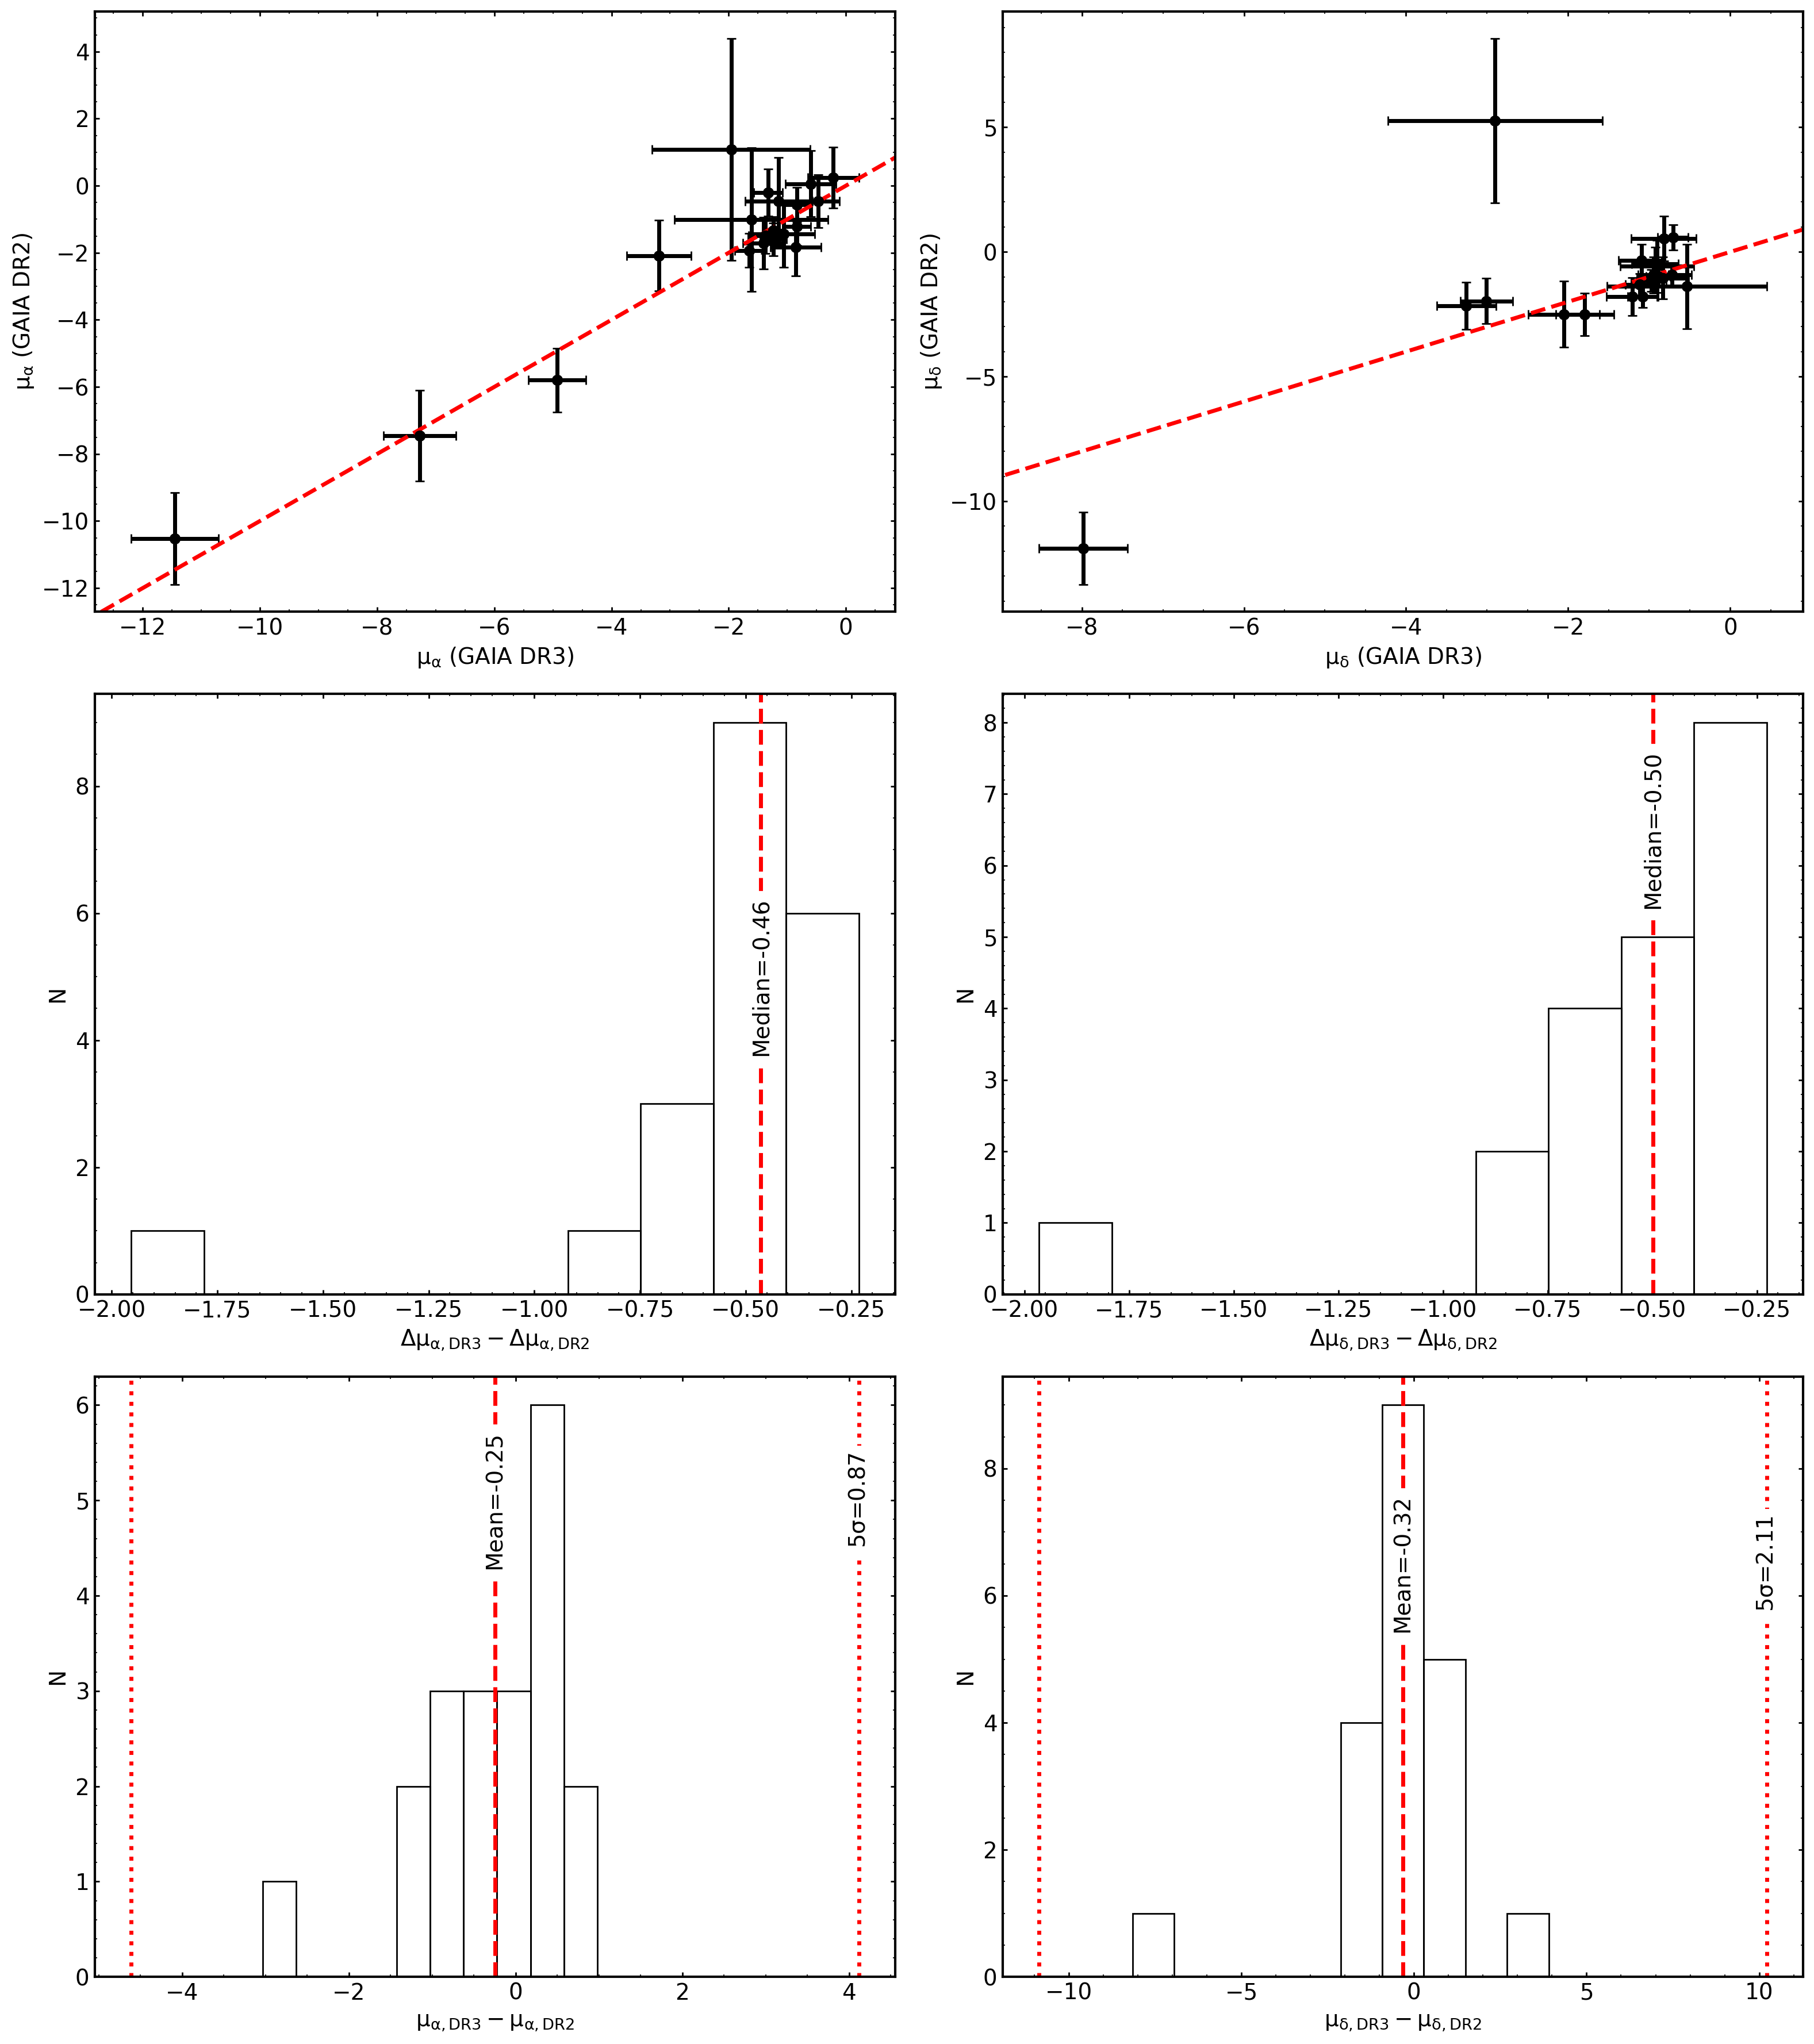

In [109]:
fig, axs = plt.subplots(3,2,figsize=(16,18))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()

# first plot the proper motion from DR2 to DR3
ax1.errorbar(
    data.pmra_dr3, 
    data.mu_alpha_dr2.astype(float),
    xerr = data.pmra_error_dr3,
    yerr = data.mu_alpha_err_dr2.astype(float),
    linestyle="none",
    marker="o",
    color="k"
)

ax1.set_ylabel(r"$\mu_\alpha$ (GAIA DR2)")
ax1.set_xlabel(r"$\mu_\alpha$ (GAIA DR3)")

ylim = ax1.get_ylim()
xlim = ax1.get_xlim()
x=y=np.linspace(*ylim)
ax1.plot(x,y,linestyle='--',color='r')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.errorbar(
    data.pmdec_dr3, 
    data.mu_delta_dr2.astype(float),
    xerr = data.pmdec_error_dr3,
    yerr = data.mu_delta_err_dr2.astype(float),
    linestyle="none",
    marker="o",
    color="k"
)

ax2.set_ylabel(r"$\mu_\delta$ (GAIA DR2)")
ax2.set_xlabel(r"$\mu_\delta$ (GAIA DR3)")

ylim = ax2.get_ylim()
xlim = ax2.get_xlim()
x=y=np.linspace(*ylim)
ax2.plot(x,y,linestyle='--',color='r')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

# Then a histogram of the difference in the uncertainties
err_diff = data.pmra_error_dr3 - data.mu_alpha_err_dr2.astype(float)
med = np.nanmedian(err_diff)
ax3.hist(err_diff, color='k', fill=False)
ax3.set_xlabel(r"$\Delta \mu_{\alpha,DR3} - \Delta \mu_{\alpha,DR2}$")
ax3.set_ylabel("N")
ax3.axvline(med, linestyle='--', color='r')
ax3.text(med, 5, f"Median={med:.2f}", rotation=90, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")

err_diff = data.pmdec_error_dr3 - data.mu_delta_err_dr2.astype(float)
med = np.nanmedian(err_diff)
ax4.hist(err_diff, color='k', fill=False)
ax4.set_xlabel(r"$\Delta \mu_{\delta,DR3} - \Delta \mu_{\delta,DR2}$")
ax4.set_ylabel("N")
ax4.axvline(med, linestyle='--', color='r')
ax4.text(med, 6.5, f"Median={med:.2f}", rotation=90, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")

# then a histogram of the difference in the proper motion values
diff = data.pmra_dr3 - data.mu_alpha_dr2.astype(float)
mean = np.nanmean(diff)
std = np.nanstd(diff)

ax5.hist(diff, color='k', fill=False)
ax5.set_xlabel(r"$\mu_{\alpha,DR3} - \mu_{\alpha,DR2}$")
ax5.set_ylabel("N")
ax5.axvline(mean, linestyle='--', color='r')
ax5.axvline(mean+5*std, linestyle=':', color='r')
ax5.axvline(mean-5*std, linestyle=':', color='r')
ax5.text(mean, 5, f"Mean={mean:.2f}", rotation=90, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")
ax5.text(mean+5*std, 5, rf"$5\sigma$={std:.2f}", rotation=90, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")

diff = data.pmdec_dr3 - data.mu_delta_dr2.astype(float)
mean = np.nanmean(diff)
std = np.nanstd(diff)

ax6.hist(diff, color='k', fill=False)
ax6.set_xlabel(r"$\mu_{\delta,DR3} - \mu_{\delta,DR2}$")
ax6.set_ylabel("N")
ax6.axvline(mean, linestyle='--', color='r')
ax6.axvline(mean+5*std, linestyle=':', color='r')
ax6.axvline(mean-5*std, linestyle=':', color='r')
ax6.text(mean, 6.5, f"Mean={mean:.2f}", rotation=90, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")
ax6.text(mean+5*std, 6.5, rf"$5\sigma$={std:.2f}", rotation=90, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")

($\mu_a~\cos\delta$, $\mu_\delta$) = (-1.39, -1.44) $\pm$ (0.69, 0.92)


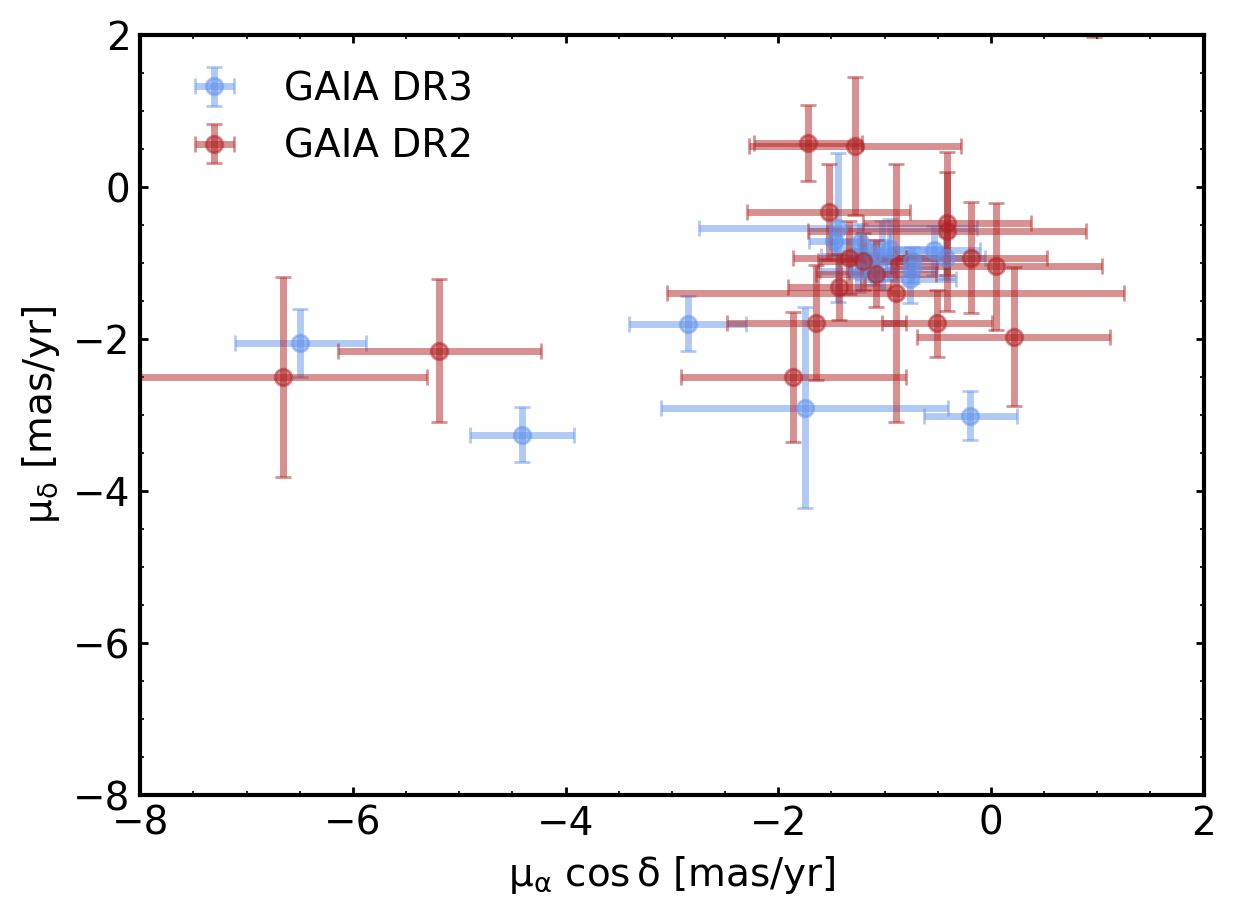

In [110]:
# compute the error weighted mean
pmra, pmra_wt = data.pmra_dr3[~pd.isna(data.pmra_dr3)], data.pmra_error_dr3[~pd.isna(data.pmra_dr3)]
pmdec, pmdec_wt = data.pmdec_dr3[~pd.isna(data.pmdec_dr3)], data.pmdec_error_dr3[~pd.isna(data.pmdec_dr3)]

where_not_outlier = pmra*np.cos(data.dec_dr3 * np.pi/180) > -4
pmra = pmra[where_not_outlier]
pmra_wt = pmra_wt[where_not_outlier]
pmdec = pmdec[where_not_outlier]
pmdec_wt = pmdec_wt[where_not_outlier]

mean_pmra = np.average(pmra, weights=pmra_wt)
std_pmra = np.sqrt(np.average((pmra-mean_pmra)**2, weights=pmra_wt))

mean_pmdec = np.average(pmdec, weights=pmdec_wt)
std_pmdec = np.sqrt(np.average((pmdec-mean_pmdec)**2, weights=pmdec_wt))

print(rf"($\mu_a~\cos\delta$, $\mu_\delta$) = ({mean_pmra:.2f}, {mean_pmdec:.2f}) $\pm$ ({std_pmra:.2f}, {std_pmdec:.2f})")

# make plot similar to Fig. 1 from the paper

fig, ax = plt.subplots()

ax.errorbar(
    data.pmra_dr3*np.cos(data.dec_dr3 * np.pi/180),
    data.pmdec_dr3,
    xerr=data.pmra_error_dr3,
    yerr=data.pmdec_error_dr3,
    linestyle="none",
    marker='o', 
    label="GAIA DR3",
    color='cornflowerblue',
    alpha=0.5
)

ax.errorbar(
    data.mu_alpha_dr2.astype(float)*np.cos(data.delta_dr2.astype(float) * np.pi/180),
    data.mu_delta_dr2.astype(float),
    xerr=data.mu_alpha_err_dr2.astype(float),
    yerr=data.mu_delta_err_dr2.astype(float),
    linestyle="none",
    marker='o',
    label="GAIA DR2",
    color='firebrick',
    alpha=0.5
)

ax.set_ylabel(r"$\mu_\delta$ [mas/yr]")
ax.set_xlabel(r"$\mu_\alpha~\cos\delta$ [mas/yr]")

ax.set_ylim(-8, 2)
ax.set_xlim(-8, 2)

ax.legend()

### Problem 1c Discussion
I get a mean proper motion, weighted by the uncertainties, of ($\mu_a~\cos\delta$, $\mu_\delta$) = (-1.39, -1.44) $\pm$ (0.69, 0.92) from the Gaia DR3 dataset. This is consistent with the value from Gaia DR2 within $1\sigma$. Although, interestingly, the uncertainties on the mean are much larger for DR3 than DR2. I'm not sure how it was computed in the paper, but I did did a weighted standard deviation to compute the statistical uncertainty.


In [132]:
isofile = "fehm20afem2.SDSSugriz"
boo3_distance = 46.5 # kpc, from the paper

def M_to_m(M, d=boo3_distance):
    return M + 5*np.log10(d/10)

with open(isofile, 'r') as f:
    iso_data = f.readlines()

hdr = iso_data[0:6]
iso_data = iso_data[6:]

hdr_vals = [val.strip() for val in hdr[3].split(' ') if val not in {'#', ''}]
mix_len, Y, Z, Zeff, Fe_H, a_Fe = hdr_vals

isochrones_in_this_file = []
base_iso = dict(
    idx = [],
    M = [],
    LogTeff = [],
    LogG = [],
    LogL = [],
    u = [],
    g = [],
    r = [],
    i = [],
    z = [],
    age = [],
    mix_len = [],
    Y = [],
    Z = [],
    Zeff = [],
    Fe_H = [],
    a_Fe = [],
)
iso = deepcopy(base_iso)
age = None

for j in range(len(iso_data)):
    if iso_data[j] == '\n':
        continue

    if '#AGE' in iso_data[j]:
        isochrones_in_this_file.append(pd.DataFrame(iso))

        age = float(iso_data[j].split(" EEPS=")[0].split("AGE=")[1].strip())
        iso = deepcopy(base_iso)
        continue

    if '#' == iso_data[j][0]:
        # this line is a header
        continue


    line = iso_data[j]
    goodline = [val for val in line.strip().split(' ') if len(val) > 0]

    if len(goodline) != 10:
        print(goodline)
        continue 

    for val, key in zip(goodline, iso.keys()):
        # if key == 'age': continue
        iso[key].append(val)

    iso['age'].append(age)
    iso['mix_len'].append(mix_len)
    iso['Y'].append(Y)
    iso['Z'].append(Z)
    iso['Zeff'].append(Zeff)
    iso['Fe_H'].append(Fe_H)
    iso['a_Fe'].append(a_Fe)
    
iso_data = pd.concat(isochrones_in_this_file).reset_index(drop=True)

# select just the 10 Gyr one
iso_data = iso_data[iso_data.age == 10]

# scale all of the magnitudes to boo3_distance
for filt in ["u", "g", "r", "i", "z"]:
    iso_data[filt] = M_to_m(iso_data[filt].astype(float), d=boo3_distance*1e3)

iso_data

,idx,M,LogTeff,LogG,LogL,u,g,r,i,z,age,mix_len,Y,Z,Zeff,Fe_H,a_Fe
7068,12,0.103511,3.5376,5.3748,-2.8181,36.404765,32.468665,30.781265,30.051865,29.662965,10.0,1.9380,0.2452,1.2990E-04,1.6990E-04,-2.01,-0.20
7069,13,0.113801,3.5502,5.3310,-2.6829,35.490765,31.976365,30.362465,29.705465,29.342965,10.0,1.9380,0.2452,1.2990E-04,1.6990E-04,-2.01,-0.20
7070,14,0.125317,3.5628,5.2860,-2.5455,34.679065,31.476965,29.948765,29.348765,29.010965,10.0,1.9380,0.2452,1.2990E-04,1.6990E-04,-2.01,-0.20
7071,15,0.138532,3.5743,5.2421,-2.4122,33.980765,30.999365,29.558465,29.001365,28.684265,10.0,1.9380,0.2452,1.2990E-04,1.6990E-04,-2.01,-0.20
7072,16,0.152713,3.5827,5.2041,-2.2982,33.447165,30.609265,29.235965,28.706265,28.403265,10.0,1.9380,0.2452,1.2990E-04,1.6990E-04,-2.01,-0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7331,275,0.856466,3.6502,0.7935,3.1312,18.666965,16.462765,15.466865,15.087665,14.876465,10.0,1.9380,0.2452,1.2990E-04,1.6990E-04,-2.01,-0.20
7332,276,0.856473,3.6486,0.7629,3.1556,18.667265,16.425365,15.414365,15.029165,14.814465,10.0,1.9380,0.2452,1.2990E-04,1.6990E-04,-2.01,-0.20
7333,277,0.856479,3.6471,0.7331,3.1795,18.669365,16.389665,15.363365,14.972265,14.754065,10.0,1.9380,0.2452,1.2990E-04,1.6990E-04,-2.01,-0.20
7334,278,0.856486,3.6457,0.7042,3.2026,18.672265,16.355565,15.314365,14.917465,14.695765,10.0,1.9380,0.2452,1.2990E-04,1.6990E-04,-2.01,-0.20


In [246]:
boo3_distance = 46.5 # kpc, from the paper
boo3_delta_distance = 2 # kpc, the value used in the paper
boo3_radius = 30 # arcmin, value used for the cone search in the paper
pmra_min, pmra_max = (-3, 1) # mu_alpha * cos(delta) in mas/yr
pmdec_min, pmdec_max = (-3, 1) # mu_delta in mas/yr

# Color-magnitude filter: this requires stars to be within
# 0.1 mag at g0 = 16, increasing linearly to 0.2 mag width at g0 = 22.5
def cmd_filter(g_mag):
    p = np.polyfit(np.linspace(16, 22.5), np.linspace(0.1,0.2), 1)
    cmd_filter = np.polyval(p=p, x=g_mag)
    return cmd_filter

def is_within_cmd_filter(g_mag, r_mag, isochrone):
    filt = cmd_filter(g_mag)
    
    # find closest isochrone point
    # good enough for now
    min_idx = np.argmin(np.abs(g_mag-isochrone.g.values))
    g, r = isochrone.g.values[min_idx], isochrone.r.values[min_idx]
    
    color = g_mag - r_mag
    
    return color <= (g-r+filt) and color >= (g-r-filt)

In [257]:
# first do a cone search in Gaia DR3
Gaia.ROW_LIMIT = 100_000
boo3_coord = SkyCoord(209.3, 26.8, unit=u.deg)
res = Gaia.query_object(
    coordinate=boo3_coord, 
    radius=boo3_radius*u.arcmin,
    verbose=False
)

# filter on proper motion
ra_res = res[(res["pmra"]*np.cos(res["ra"].to(u.radian)) > pmra_min) * (res["pmra"]*np.cos(res["ra"].to(u.radian)) < pmra_max)]
dec_res = ra_res[(ra_res["pmdec"] > pmdec_min) * (ra_res["pmdec"] < pmdec_max)]

# filter on the CMD cuts
res = get_sdss_colors(dec_res.to_pandas())

res["is_within_cmd_filter"] = res.apply(
    lambda row : is_within_cmd_filter(row.g_sdss, row.r_sdss, iso_data),
    axis=1
)
    
res = res[res.is_within_cmd_filter]

# filter on g_0
res = res[res.g_sdss < 20]

/tmp/ipykernel_847230/2148086655.py:22: UserWarning: Skipping Gaia DR3 1450837238169921280 because no SDSS data!
  warnings.warn(f"Skipping {row.DESIGNATION} because no SDSS data!")


(-0.8, 1.8)

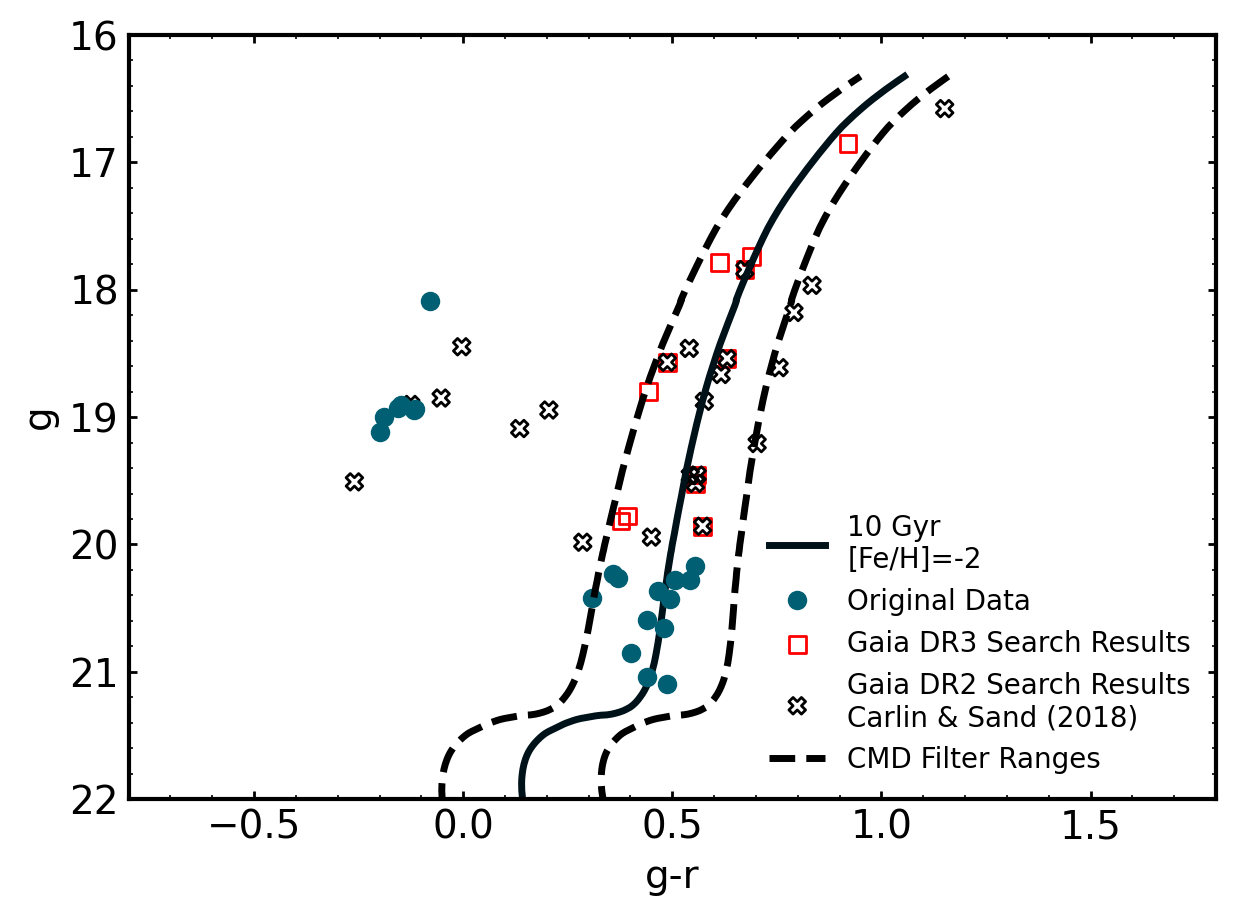

In [264]:
# read in Table 2 from Carlin & Sand (2018)
dr2_res = pd.read_csv("Carlin_and_Sand_2018_Table2.txt", sep="\t")
dr2_res = get_sdss_colors(dr2_res, ra_key="alpha", dec_key="delta")

# then plot it up!
fig, ax = plt.subplots()

ax.plot(iso_data.g.astype(float)-iso_data.r.astype(float), iso_data.g.astype(float), label="10 Gyr\n[Fe/H]=-2")

ax.plot(data.g_sdss-data.r_sdss, data.g_sdss, marker='o', linestyle='none', label="Original Data")
ax.scatter(res.g_sdss-res.r_sdss, res.g_sdss, marker='s', edgecolor='r', facecolor="none", label="Gaia DR3 Search Results")
ax.scatter(dr2_res.g_sdss-dr2_res.r_sdss, dr2_res.g_sdss, marker='X', edgecolor='k', facecolor="none", label="Gaia DR2 Search Results\nCarlin & Sand (2018)")

ax.plot(
    iso_data.g.astype(float)-iso_data.r.astype(float) + cmd_filter(iso_data.g.astype(float)),
    iso_data.g.astype(float),
    linestyle='--',
    color='k',
    label = "CMD Filter Ranges"
)
ax.plot(
    iso_data.g.astype(float)-iso_data.r.astype(float) - cmd_filter(iso_data.g.astype(float)),
    iso_data.g.astype(float),
    linestyle='--',
    color='k'
)
ax.invert_yaxis()
ax.set_xlabel("g-r")
ax.set_ylabel("g")

ax.legend(fontsize=10)

ax.set_ylim(22, 16)
ax.set_xlim(-0.8, 1.8)

#### Problem 1d Discussion

We used the same proper motion filter, same color-magnitude diagram filter, and maximum $g < 20$ from Carlin & Sand (2018) to search for plausible main sequence and red giant branch proper motion members of Bootes III. The results are shown in the figure above.

From the SDSS colors and Isochrones (from HW 1), we find 7 new proper motion members of Bootes III. The Isochrone shown is for a 10 Gyr cluster with a metallicity $[Fe/H]=-2$. Note that we do not find some of the original members from Carlin & Sand (2018) for two primary reasons:

1. We use SDSS magnitudes instead of Panstarrs magnitudes. This is because the Isochrone we have access to is for SDSS magnitudes. This changes the exact width of the Color Magnitude Diagram filter and eliminates some of them.
2. The Isochrone we are using does not include the population of bluer stars on the right side of the color-magnitude diagram. This is a limitation of this analysis.

Additionally, it is important to note that these are simply **plausible** members of Bootes III that need true RV measurements to confirm. As described in Carlin & Sand (2018), there are numerous sources of contaminants for these proper motion calculations.

### Problem 2

Congratulations! You have discovered a dwarf galaxy around the Milky Way. Wishing to refine it’s
distance, you took time series imaging data of this new system and identified 3 RR Lyrae stars, whose proper-
ties are in the data file “rrl.dat”. Infer the distance to the new dwarf galaxy using the basic relations in Caceres & Catelan 2008, ApJSS, 179, 242. You can assume a metallicity of Z=0.0001, but assume a 10% uncertainty on this value. For the average i and z band magnitudes, you can assume 0.03 mag uncertainties, and a 0.01 day
uncertainty on the RRL periods. What is the distance (with uncertainty) to your newly discovered dwarf galaxy?

The relevant equations in Caceres & CAtelan (2008) are equations (6) and (7):

$M_z = 0.839 - 1.295~\log P + 0.211~\log Z$

$M_i = 0.908 - 1.035~\log P + 0.220~\log Z$

Which has the general form
$M_f = \gamma - \alpha~\log P + \beta~\log Z$

From these we can use the distance modulus equation to find the distance to each RR Lyrae Star

$m - M = 5\log d - 5 \rightarrow \log d = \frac{m - M + 5}{5}$

Substituting in the general formulation of M

$\log d_f = \frac{1}{5} \left[ m_f - \gamma + \alpha~\log P - \beta~\log Z + 5 \right]$


Which then, propagating uncertainty, has an uncertainty of

$\sigma_d = d_f \left[\left(\alpha\frac{\sigma_P}{\ln(10)~ P}\right)^2 + \left(\beta\frac{\sigma_Z}{\ln(10)~Z}\right)^2 + \left(\frac{\sigma_m}{m_f}\right)^2 \right]^{1/2}$

In [12]:
def log_distance(P, sigma_P, Z, sigma_Z, m, sigma_m, alpha, beta, gamma):
    log_d = 1/5 * (m - gamma + alpha*np.log10(P) - beta*np.log10(Z) + 5)
    sigma_d = log_d * ( (alpha*sigma_P/(np.log(10)*P))**2 + (beta*sigma_Z/(np.log(10)*Z))**2 + (sigma_m/m)**2 )**0.5
    
    return log_d, sigma_d

In [13]:
rr_lyrae = pd.read_csv("rrl.dat", sep=' ')

rr_lyrae["Z"] = 0.0001
rr_lyrae["Z_err"] = 0.1*rr_lyrae.Z

rr_lyrae["i_mag_err"] = 0.03
rr_lyrae["z_mag_err"] = 0.03

rr_lyrae["Period_err"] = 0.01

i_band_kwargs = dict(
    alpha = 1.035,
    beta = -0.220,
    gamma = 0.908
)

z_band_kwargs = dict(
    alpha = 1.295,
    beta = -0.211,
    gamma = 0.839
)

rr_lyrae['log_d_i'], rr_lyrae['log_d_i_err'] = log_distance(
    rr_lyrae["Period(d)"],
    rr_lyrae.Period_err,
    rr_lyrae.Z,
    rr_lyrae.Z_err,
    rr_lyrae.i_mag,
    rr_lyrae.i_mag_err,
    **i_band_kwargs
)

rr_lyrae['log_d_z'], rr_lyrae['log_d_z_err'] = log_distance(
    rr_lyrae["Period(d)"],
    rr_lyrae.Period_err,
    rr_lyrae.Z,
    rr_lyrae.Z_err,
    rr_lyrae.z_mag,
    rr_lyrae.z_mag_err,
    **z_band_kwargs
)

rr_lyrae

,Name,RA(deg),DEC(deg),Period(d),i_mag,z_mag,A_i,A_z,Z,Z_err,i_mag_err,z_mag_err,Period_err,log_d_i,log_d_i_err,log_d_z,log_d_z_err
0,RRL1,189.570323,-40.939879,0.389918,20.92,20.86,0.192,0.146,0.0001,0.00001,0.03,0.03,0.01,4.741731,0.071321,4.729462,0.081105
1,RRL2,189.633635,-40.878072,0.422481,20.88,20.83,0.203,0.155,0.0001,0.00001,0.03,0.03,0.01,4.740942,0.068136,4.732484,0.076786
2,RRL3,189.584351,-41.101214,0.735898,20.67,20.59,0.177,0.135,0.0001,0.00001,0.03,0.03,0.01,4.748831,0.054291,4.746906,0.057062


In [282]:
def print_results(log_dist, log_dist_err, varname):
    
    dist = 10**log_dist
    dist_err = log_dist_err * dist/log_dist
    
    print(fr"${varname}$ = {dist/1e3:.2f} $\pm$ {dist_err/1e3:.2f} kpc")

print_results(rr_lyrae.log_d_z.mean(), rr_lyrae.log_d_z_err.mean(), "d_z")
print_results(rr_lyrae.log_d_i.mean(), rr_lyrae.log_d_i_err.mean(), "d_i")

$d_z$ = 54.49 $\pm$ 0.82 kpc
$d_i$ = 55.44 $\pm$ 0.75 kpc


### Problem 2 Discussion

The full results of the distance calculations for these three RR Lyrae stars are shown in the table above. Since I compute the distance in both z-band and i-band independently, we get two measurements of the distance. These measurements, which I get by averaging the log distance results, are consistent within uncertainties and give a distance of $d\sim (55\pm1) kpc$.  

### Problem 3

Black Hole Accretion Time Scales As a mass m of gas falls into a black hole, at most 0.1mc2 is
likely to emerge as radiation; the rest is swallowed by the black hole. Show that the Eddington luminosity for
a black hole of mass M is equivalent to 2×10−9 M c2 yr−1. Explain why we expect the black hole’s mass to
grow by at least a factor of e every 5 × 107 years.

We start by deriving the eddington luminosity in a typical way

$F_g = F_{rad}$

$\frac{G M m_p}{r^2} = \frac{ \sigma_T L_{edd} }{ 4 \pi c r^2 }$

Solving for $L_{edd}$

$L_{edd} = \frac{4\pi G m_p}{c \sigma_T} Mc^2$

Or in terms of years

$L_{edd} = \frac{1.261\times10^8 \pi G m_p}{c \sigma_T} \frac{M c^2}{yr}$

In [21]:
sec_to_year = 3600 * 24 * 365 * u.s / u.yr
print(f"{sec_to_year*4:.2e}")

res_factor = 4*sec_to_year * np.pi * c.G * c.m_p / (c.c * c.sigma_T)
res_factor

1.26e+08 s / yr


<Quantity 2.2182837e-09 1 / yr>

Using the above calculations

$L_{edd} = 2.22\times10^{-9} Mc^2 yr^{-1}$

We can also write a mass accretion rate

$ \dot{M}_{edd} = \frac{L_{edd}}{\epsilon c^2} = \frac{2.22\times10^{-9} M}{\epsilon} yr^{-1}$

We are given $\epsilon = 0.1$ in the problem giving an equation

$ \dot{M}_{edd} = 2.22\times10^{-8} M yr^{-1} $

Integrating the mass from $M_0 \rightarrow eM_0$ and from $t=0 \rightarrow t=\tau$ for an e-folding time $\tau$ gives

$\int_{M_0}^{e M_0} \dot{M}_{edd} dM = 2.22\times10^{-8}  yr^{-1} \int^{\tau}_{0} M dt$

Assuming an exponential growth from $M_0 \rightarrow eM_0$ then we have a functional form $M = M_0 e^{t/\tau}$

$M_0 (e-1) = 2.22\times10^{-8}  M_0 yr^{-1} \int^{\tau}_{0} e^{t/\tau} dt$

$M_0 (e-1) = 2.22\times10^{-8}  M_0 yr^{-1} \tau (e - 1)$

Simplifying gives a timescale

$\tau = \frac{yr}{2.22\times10^{-8}} = 4.5\times10^7 yr$

In [283]:
f"{(1/2.22e-8):.2e} yr"

'4.50e+07 yr'

### Problem 4

Closed Box Enrichment In a scenario where stars are made from gas that is initially free of metals,
so Z(t=0)=0, what is the mean metal abundance of stars once all of the gas is gone?

**My Solution**

The average stellar metalicity is defined as 

$ <z_s> = \frac{M_z}{M_s} $

Where $M_z$ is the mass of the metals and $M_s$ is the stellar mass. At some time t, when $M_g = 0$ (ie all the gas was used up to make stars), we know that $M_{tot} = M_s$ giving

$ <z_s> = \frac{M_z}{M_s} $

For an outer shell on the star $\delta M_s$, 

$ M_z = \int_0^t z(t) \delta M_s $

Changing variables to $M_g$

$ M_z = -\int_{M_{tot}}^0 z(M_g) \delta M_g $

Using the equation for $z(M_g)$ derived in class gives an integral

$ M_z = P \int_{M_{tot}}^0 \ln\left(\frac{M_g}{M_{tot}}\right) \delta M_g $

$ M_z = P \left[ M_g \left( \ln\frac{M_g}{M_{tot}} - 1 \right) \right]^0_{M_{tot}}$

$ M_z = P \left[ 0 + M_g\right]$

$ M_z = P ~ M_g $

Substituting this back into the equation for $<z_s>$ gives

$\boxed{<z_s> = P}$